*This cannot go before thanking the Kaggle community for clearing many doubts! Thank you all so much. I complied my learning into this EDA, and hope that this will be helpful to all range of audience here*.

The ideas on processing dicoms are inspired by this **titan level** tutorial :

* **https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial** || Do give it a shot post reading this notebook!


# OSIC Pulmonary Fibrosis Progression

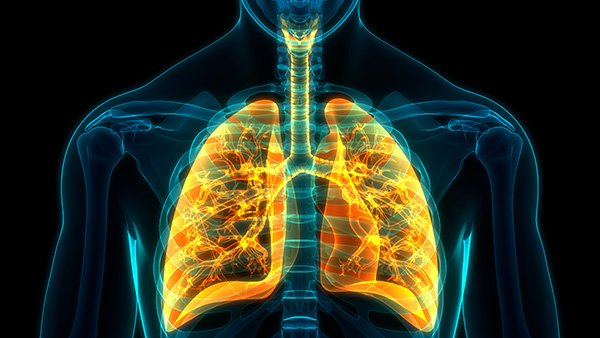

## Book One - Exploratory Data Analysis (EDA)

In [ ]:
import os

Each of these IDs encapsulates the CT scans of that patient, over a span of time commencing from week 0.

In [ ]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import skew

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly
import plotly.graph_objects as go
%matplotlib inline
import cv2
import pydicom
import glob
# formatting libraries
from colorama import Fore
from tqdm import tqdm_notebook as tqdm

import gc

Colorama provides a simple cross-platform API to print colored terminal text from Python applications. It's useful for projecting results in a visually appealing manner. 

# Loading Mandatory Files

In [ ]:
train = pd.DataFrame(pd.read_csv("../input/osic-pulmonary-fibrosis-progression/train.csv"))
print(Fore.YELLOW+"Shape Of Train Dataframe = ", train.shape)

In [ ]:
train.head()

In [ ]:
train.info()

This is great, as we don't have any missing values! Let's analyze for the test set also.

In [ ]:
test = pd.DataFrame(pd.read_csv("../input/osic-pulmonary-fibrosis-progression/test.csv"))
print(Fore.BLUE+"Shape Of Testing Dataframe = ", test.shape)

In [ ]:
test

No missing values either!

Let's observe the number of unique patients we have out of 1549 overall entries.

In [ ]:
unique_count = len(train["Patient"].unique())
print(Fore.YELLOW+"Number of unique entries out of 1549 overall record = ", unique_count)

In [ ]:
train.head()

In [ ]:
patient_ids = os.listdir("../input/osic-pulmonary-fibrosis-progression/train")
len(os.listdir("../input/osic-pulmonary-fibrosis-progression/train"))

So, we have the IDs corresponding to each patient now. Let's display the first five entries.

In [ ]:
patient_ids[:5]

# Custom DataFrame Creation

In order to perform EDA relatively more easily, let's create a custom dataframe having attributes corresponding to each patient. 

**How is it different from the original one?**

*This dataframe will only have the Age, sex and smoking status attribute corresponding to each person. Using this way we will analyze the distribution of patients centered around these attributes. Analysis of CT Scans will be done later in the notebook.*

In [ ]:
def create_custom_dataframe(df, directory) : 
    
    unique_count = len(df["Patient"].unique())
    dataframe = pd.DataFrame(index = np.arange(unique_count), columns = ["patient_id", "age", "sex",
                                                                             "smoking_status", "num_of_scans_available"])
    patient_ids = os.listdir(directory)
    
    i = 0 
    for patient_id in tqdm(patient_ids) : 
        subset_frame = df[df["Patient"] == patient_id]
        age = subset_frame["Age"].values[0]
        sex = subset_frame["Sex"].values[0]
        smoking_status = subset_frame["SmokingStatus"].values[0]
        num_of_scans_available = len(os.listdir(directory + patient_id))
        
        dataframe.iloc[i]["patient_id"] = patient_id
        dataframe.iloc[i]["age"] = age
        dataframe.iloc[i]["sex"] = sex
        dataframe.iloc[i]["smoking_status"] = smoking_status
        dataframe.iloc[i]["num_of_scans_available"] = num_of_scans_available
        
        i += 1
    return dataframe

In [ ]:
train_dataframe = create_custom_dataframe(train, directory = "../input/osic-pulmonary-fibrosis-progression/train/")
test_dataframe = create_custom_dataframe(test, directory = "../input/osic-pulmonary-fibrosis-progression/test/")

print(Fore.YELLOW +"Shape of the TRAIN custom dataframe = ", train_dataframe.shape)
print(Fore.BLUE +"Shape of the TEST custom dataframe = ", test_dataframe.shape)

In [ ]:
train_dataframe.head()

In [ ]:
test_dataframe

Hence, the custom dataframe creation is complete. Now, we have a subset of attributes corresponding to each patient ID without duplicate IDs repeating incessantly. Number of scans per ID are also made available in this dataframe.

# Analyzing Distribution

## Sex Distribution : 

In [ ]:
train_male_count = len(train_dataframe[train_dataframe["sex"] == "Male"])
train_female_count = len(train_dataframe[train_dataframe["sex"] == "Female"])

test_male_count = len(test_dataframe[test_dataframe["sex"] == "Male"])
test_female_count = len(test_dataframe[test_dataframe["sex"] == "Female"])

labels = ["Male", "Female"]
size = [train_male_count, train_female_count]
explode = [0.1, 0.0]

plt.figure(figsize = (16, 16))
plt.subplot(1,2,1)
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["brown", "cyan"])
plt.title("Male VS Female Count - TRAIN", fontsize = 18)
plt.legend()
print(Fore.YELLOW+"Number of males in training set = ", train_male_count)
print(Fore.BLUE+"Numver of females in training set = ", train_female_count)
print("\n")

size = [test_male_count, test_female_count]
plt.subplot(1,2,2)
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["brown", "cyan"])
plt.title("Male VS Female Count - TEST", fontsize = 18)
plt.legend()
print(Fore.YELLOW+"Number of males in test set = ", test_male_count)
print(Fore.BLUE+"Numbet of females in test set = ", test_female_count)

In [ ]:
gc.collect()

So, the data is biased when analyzed from gender point of view. It's evident that not even 25% of total IDs corresponds to females, in the training set.

## Smoking Status :

Let's observe hown many categories are there in this column.

In [ ]:
train_dataframe["smoking_status"].unique()

In [ ]:
train_ex_smoker = len(train_dataframe[train_dataframe["smoking_status"] == "Ex-smoker"])
train_never_smoked = len(train_dataframe[train_dataframe["smoking_status"] == "Never smoked"])
train_currently_smokes = len(train_dataframe[train_dataframe["smoking_status"] == "Currently smokes"])

test_ex_smoker = len(test_dataframe[test_dataframe["smoking_status"] == "Ex-smoker"])
test_never_smoked = len(test_dataframe[test_dataframe["smoking_status"] == "Never smoked"])
test_currently_smokes = len(test_dataframe[test_dataframe["smoking_status"] == "Currently smokes"])

size = [train_ex_smoker, train_never_smoked, train_currently_smokes]
labels = ["Ex-smoker", "Never smoked", "Currently smokes"]
explode = [0.1, 0.1, 0.0]

plt.figure(figsize = (16, 16))
plt.subplot(1,2,1)
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["lightblue", "darkgreen", "darkred"],
        autopct='%.2f')
plt.title("Smoking Status - TRAIN", fontsize = 18)
plt.legend()
print(Fore.YELLOW+"Ex-smoker count = ", train_ex_smoker)
print(Fore.YELLOW+"Never smoked = ", train_never_smoked)
print(Fore.YELLOW+"Currently smokes = ", train_currently_smokes)
print("\n")

size = [test_ex_smoker, test_never_smoked, test_currently_smokes]
plt.subplot(1,2,2)
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["lightblue", "darkgreen", "darkred"],
       autopct='%.2f')
plt.title("Smoking Status - TEST", fontsize = 18)
plt.legend()
print(Fore.BLUE+"Ex-smoker count = ", test_ex_smoker)
print(Fore.BLUE+"Never smoked = ", test_never_smoked)
print(Fore.BLUE+"Currently smokes = ", test_currently_smokes)

The values indicate the overall percentage of that fraction. So, we can see that our data is dominated a lot by Ex-smoker entries, followed by never smoked ones! 

## Histogram Plots : 

Most common way to gain insights into 1-D data is through Histogram plots. When dealing with a set of data, often the first thing you’ll want to do is get a sense for how the variables are distributed. The most convenient way to take a quick look at a univariate distribution in seaborn is the **distplot() function**. 

## Scans Available : 

In [ ]:
scans_available_train = train_dataframe["num_of_scans_available"].values

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
sns.distplot(scans_available_train, kde = False, rug = False, color = "darkgreen")
plt.ylabel("Scan Count", fontsize = 12)
plt.grid(True)
plt.title("Scans Available - TRAIN", fontsize = 16)

In [ ]:
plt.figure(figsize = (10, 5))
plt.subplot(1,1,1)
sns.swarmplot(scans_available_train, size = 18, alpha = 0.4, color = "gold")
plt.grid(True)
plt.title("Bee Swarm Plot For Scans - TRAIN", fontsize = 16) 

Though a beeswarm plot lack the **scientific rigor** of other plots, however they are good for visualization purposes, especially those in **categorical feature sections**. We did that with pie chart as all the necessary was conveyed through it. BeeSwarm was another alternative to that.

This can be made more informative using a 1-D BoxPlot.

In [ ]:
plt.figure(figsize = (10, 5))
plt.subplot(1,1,1)
sns.boxplot(scans_available_train, color = "brown")
sns.swarmplot(scans_available_train, size = 14, alpha = 0.3, color = "gold")
plt.grid(True)
plt.title("Box Plot For Scans - TRAIN", fontsize = 16) 

Now, this is much more informative. Let's see first a boxplot is all about. 

There appears only one prominent peak, and this agrees with the histogram plot before. Maximum patient fall into category of those having 0-200 scans per person. 

****************************

## BoxPlot : 

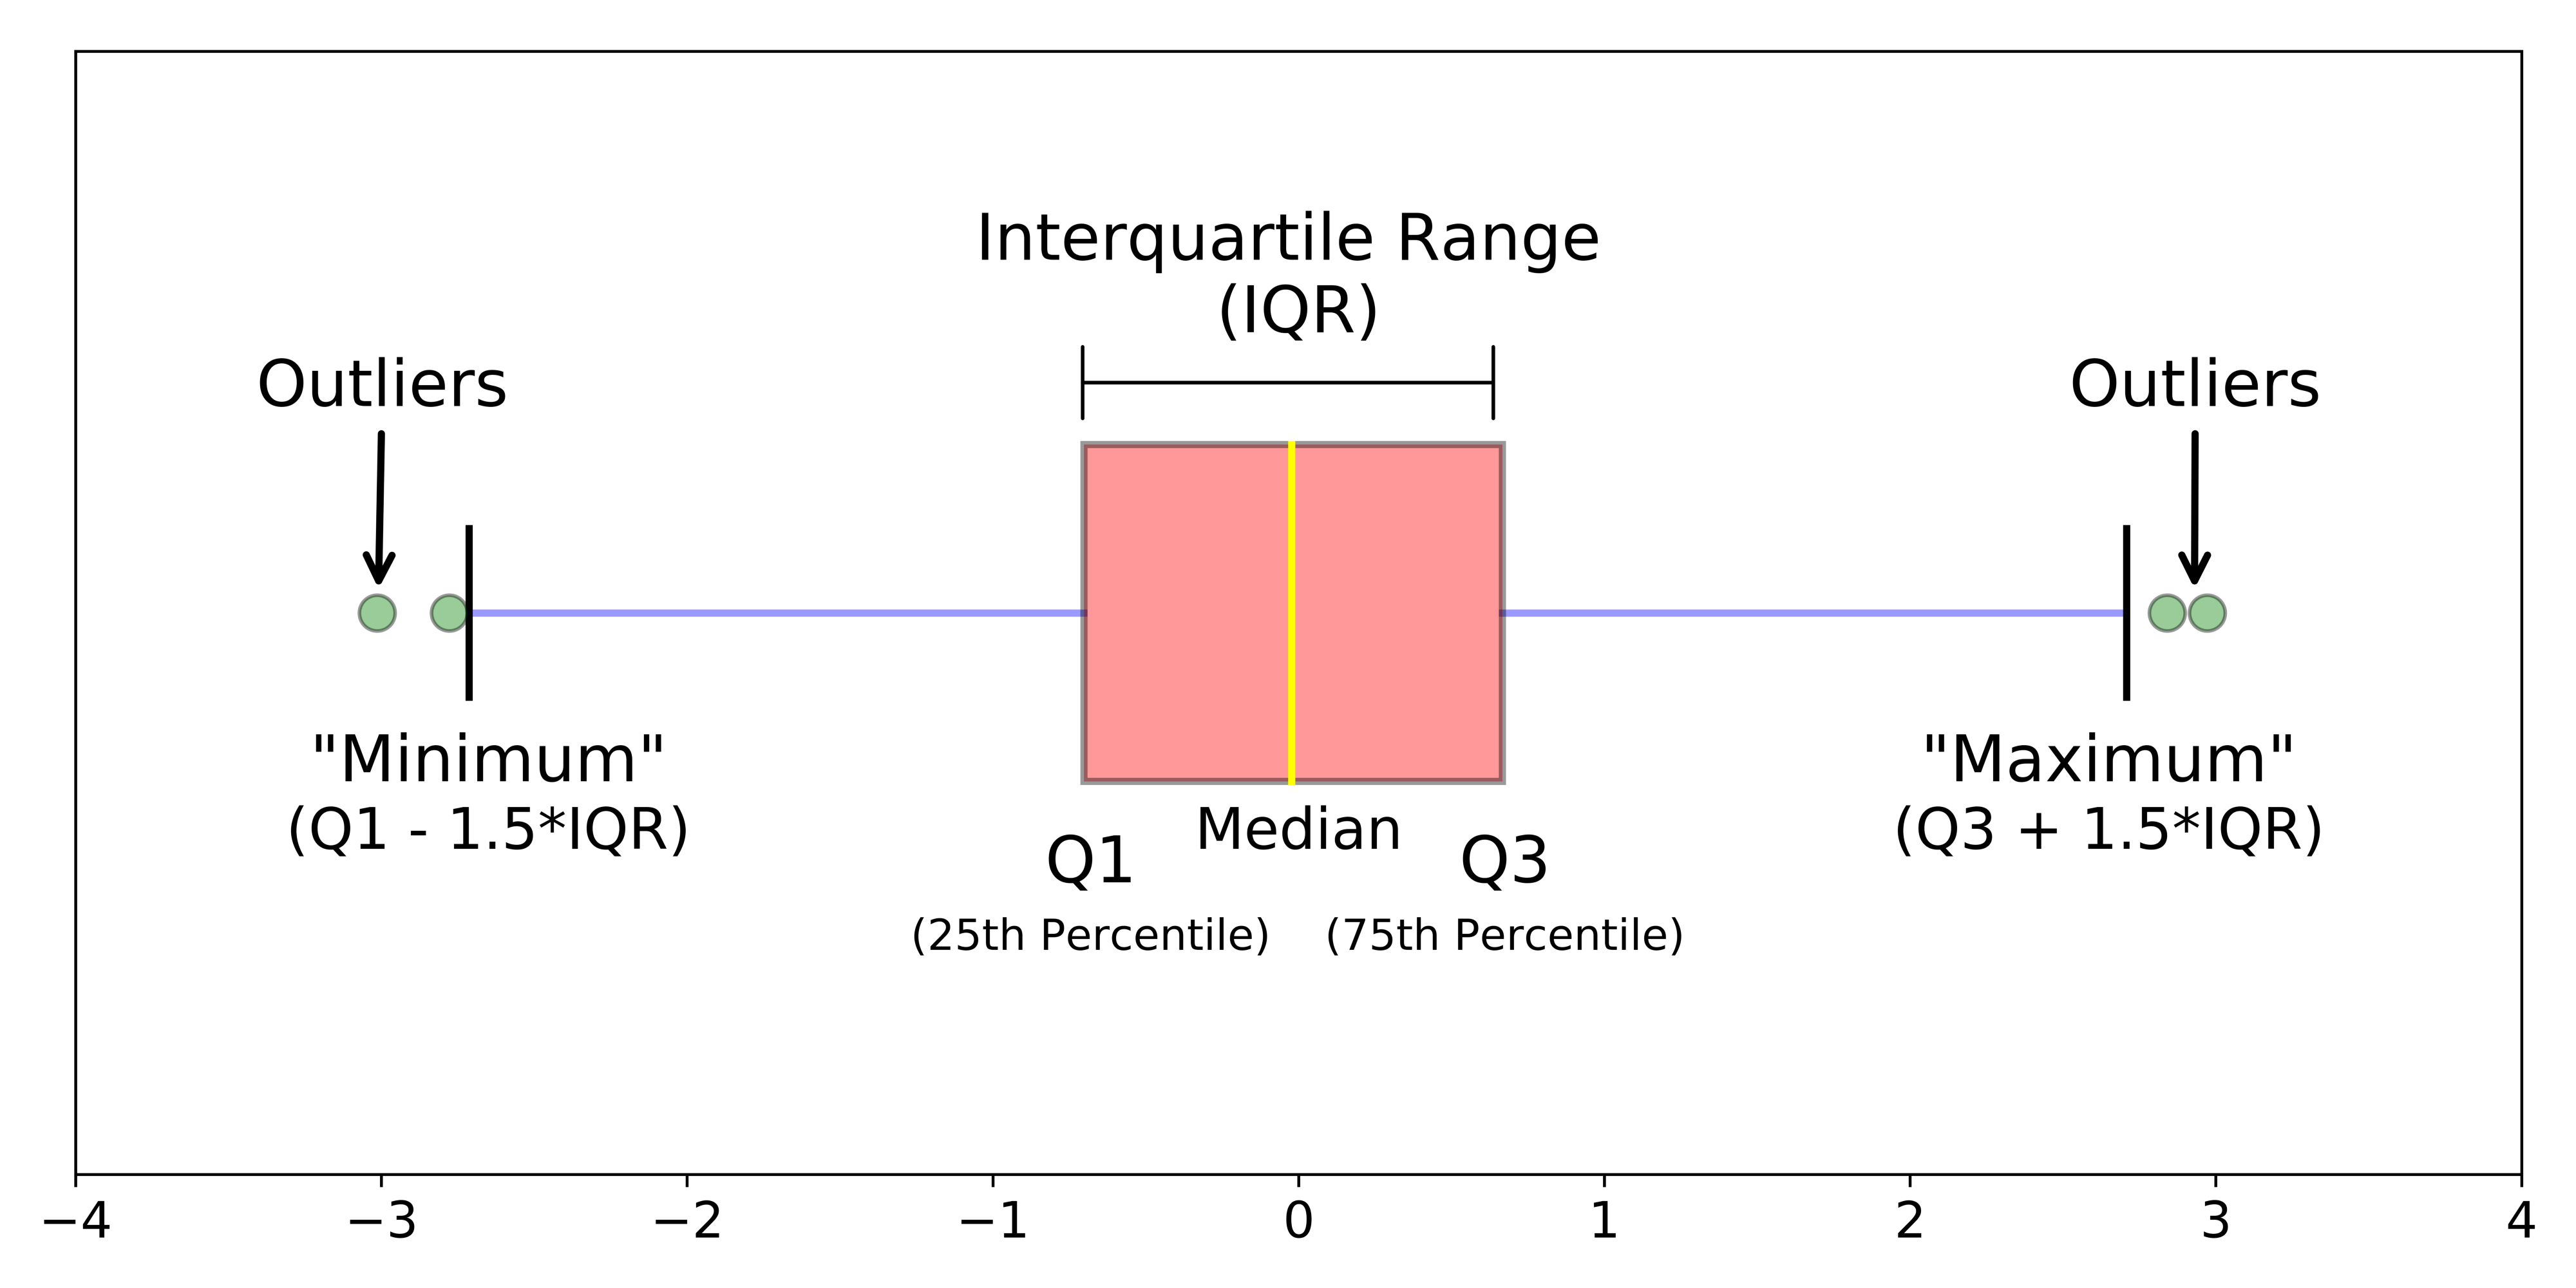 

A boxplot is all about **quartiles, which are a way of recording how our data is distributed**. A boxplot will have **25% line as the base line of the box, 50% line somewhere inside the box and the top edge of the box refers to the 75% line**. 

In other words, **25% data is below the base line of the boxplot, and 75% is above the top edge**. This helps us in analyzing the spread and skewness of the data distribution.

* So, the mid line is the 50% line denoting the mean.
* Size of the box conveys how spread out the data is!

**Combining it with bee-swarm plot dynamically increases visual appeal for ease of analysis**.

## The Top Line Of The BoxPlot - Not The Box

We can see outside the box there appears to be a prominent line, some distance below and above the box(*here right and left as the box is plot is horizontal*). This normally upper (*here right*) gap is actually **1.5 X Interquartile range**, where interqaurtile range is the distance between the 75% mark and 25% mark. 

* The points crossing the upper and lower lines are **outliers**.

This gap can be controlled via a keyword called **whis** in seaborn. By default it is 1.5

## So, what's the downside of a boxplot?

Well, if we carefully see, a boxplots condenses our distribution into **5 values**. The lower and upper ends (between the outliers) and the three inside the box(25%, mean and 75% marks). So, in a way we are losing information.

`Boxplot are primarily useful when we want to compare several distributions`. 

## A much better plot to use is a VIOLIN PLOT. 

However, here our purpose is served.

Inference : 
* The distribution of the histogram of scans available is negatively skewed. We see that people having scans of about 0-100 are quite high. More than 80.
* As number of scans increases, the number of patients decreases. 

## Sex VS Smoking Status : 

In [ ]:
sex_versus_smoking_status = train_dataframe.groupby(["sex", "smoking_status"]).size()
print(sex_versus_smoking_status)
print(type(sex_versus_smoking_status))

In [ ]:
sex_versus_smoking_status = np.log(sex_versus_smoking_status.unstack(level = 1))
print(sex_versus_smoking_status)
print(type(sex_versus_smoking_status))

In [ ]:
sns.set(style = "whitegrid")
sns.set_context("paper", rc = {"font.size" : 12, "axes.titlesize" : 20, "axes.labelsize" : 18})

plt.figure(figsize = (10, 6))
sns.heatmap(sex_versus_smoking_status, annot = True, cmap = "icefire", cbar = True)
plt.title("Sex VS Smoking Status - Log Analysis", fontsize = 18)
plt.tight_layout()

An interesting point over here is to realize that though we have an OVERALL majority of *ex-smokers* in the training data, and this is reflected as *ex-smokers males* are dominant, however in females *never smoked* category is the dominant one.

## Sex VS Scans Available : 

In [ ]:
train_male_scans = train_dataframe[train_dataframe["sex"] == "Male"]["num_of_scans_available"].sum()
train_female_scans = train_dataframe[train_dataframe["sex"] == "Female"]["num_of_scans_available"].sum()

x = ["Male Scans", "Female Scans"]
y = [train_male_scans, train_female_scans]

plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.bar(x, y, color = "r")
plt.grid(True)
plt.title("Total Scans Available - TRAIN", fontsize = 16)

Again, a disbalance we observe. Female scans are way too less when compared to males.

# Image EDA and Analysis

## Understanding DICOM images for CT Scans : 

* Standard way of representing medical images.
* The unit of measurement in CT medical scans is the Hounsfield Unit (HU), which is a measure of radiodensity
* Apart from the images, just like tfRecords, a lot of metadata can be encapsulated in a .dcm file format.
* pydicom Python3 module was made for inspecting and modifying DICOM data in an easy "pythonic" way.
* DICOM groups information into data sets. For example, a file of a chest x-ray image may contain the patient ID within the file, so that the image can never be separated from this information by mistake.
* A DICOM data object consists of a number of attributes, including items such as name, ID, etc., and also one special attribute containing the image pixel data. 

`There are so many gray level values in a CT Scan(in thousands) that it is nearly impossible for us to capture them through naked eyes! Hence, in order to extract meaningful information, we display the image in HU range that suits our current interest. For example we may set a range to view bones, and another to view tissues`.

We have several scans for each patient. For a particular ID, we will analyze all the `.dcm` images available. For this, the load_scan( ) function is written.

Each scan is referred to as a `slice` in popularly used CT terminology. 

Remember the scanner scans the patient from different positions. Hence, in order to load the full scan of a person, we ought to rearrange everything by ImagePosition attribute, embedded in the dicoms.

__________________________

So, now in the `load function` we will : 
* Input a directory as the argument 'path'.
* Inside a directory, we will have many .dcm files corresponding to a patient. For e.g. 1.dcm, 2.dcm and so on... depending on the directory ID of the person we supplied.
* Let's store all these files under the tag file_numbers. This will be arranged from the most recent number to the oldest one.
* Now, we will read these files as stored, that is the latest scan first, followed by the previous ones. All these dicom files will be read using pydicom Python3 module, and will be appended to a list named `slices`. 
* Ultimately, the list `slices` will be returned.

In [ ]:
def load_scan(path) :
    files = os.listdir(path)
    file_numbers = []
    for file in files :
        file_numbers.append(np.int(file.split(".")[0]))
    file_numbers.sort(reverse = True)
    file_numbers = np.array(file_numbers)
    
    slices = []
    for number in file_numbers :
        read_dicom_file = pydicom.dcmread(path + "/" + str(number) + ".dcm")
        slices.append(read_dicom_file)
    
    return slices

In [ ]:
train.head(2)

In [ ]:
sample_path = "../input/osic-pulmonary-fibrosis-progression/train/"+ train.Patient.values[0]
slices = load_scan(sample_path)

print(slices[0])

**Hounsfield Units** : 

Is a quantitative scale for describing radiodensity. It is frequently used in CT scans, where its value is also termed CT number. Various Hounsfield Units are listed in the table below : 

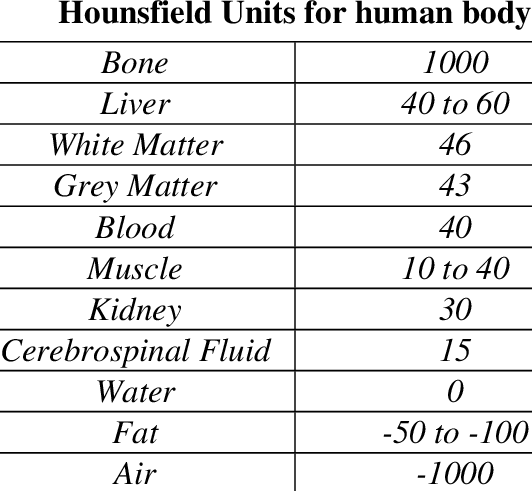 

Next function will convert the voxel values to Hounsfield Units. *Before that, let's have a look at the metadata again*.

Two extremely important things over here are the **third last and second last tag**, that is 
* Rescale slope
* Rescale Intercept

*********************************************
**Extracted from StackOverFlow : https://stackoverflow.com/questions/10193971/rescale-slope-and-rescale-intercept** : 

*The rescale slope and rescale intercept allow to transform the pixel values to HU or other units, as specified in the tag 0028,1054*.

*For CT images, the unit should be HU (Hounsfield) **and the default value is indeed HU** when the tag 0028,1054 is not present. However, the tag may be present and may specify a different unit (OD=optical density, US=unspecified)*.

*The rescale slope and intercept are determined by the manufacturer of the hardware*.
********************************************
**Extracted from A Coyote's Guide To IDL Programming : http://www.idlcoyote.com/fileio_tips/hounsfield.html**

To convert from the normal units found in CT data (a typical data set ranges from 0 to 4000 or so) you have to apply a linear transformation of the data. The equation is:

`hu = pixel_value * slope + intercept`

********************************************

## Analyze the pixel_array values, for the images in slices[0] (for sample).

In [ ]:
print(Fore.YELLOW+"Number of slices available = {}".format(len(slices)))

In [ ]:
plt.figure(figsize = (15, 8))
for i in range(30) : 
    image = slices[i].pixel_array.flatten()
    image = image * slices[i].RescaleSlope + slices[i].RescaleIntercept
    sns.distplot(image.flatten(), kde = True, hist = True)
plt.title("Distribution in Hounsfield Units", fontsize = 18); # ; to suppress the text output

The negative 3000 value is most probably air, or whatever is outside of the circular zone in which the image is captured in a CT-scan.

In the chart of HU pasted above, it's pretty evident that air starts from -1000. 

In [ ]:
def transform_to_hu(slices) : 
    scan_collection = []
    for scan in slices : 
        scan_collection.append(scan.pixel_array)
    scan_collection = np.stack(scan_collection)
    scan_collection = scan_collection.astype(np.int16)
    # setting everything outside to air.
    scan_collection[scan_collection <= -1000] = 0 
    
    for i in range(len(slices)) : 
        scan_collection[i] = slices[i].RescaleSlope * scan_collection[i].astype(np.float64)
        scan_collection[i] = scan_collection[i].astype(np.int16)
        scan_collection[i] = scan_collection[i] + np.int16(slices[i].RescaleIntercept)
    return np.array(scan_collection, dtype = np.int16)   

In [ ]:
scan_collection = transform_to_hu(slices)

In [ ]:
print(Fore.CYAN+"Shape Of the scan_collection tensor = ",scan_collection.shape)

Visualize few images from the scan_collection.

In [ ]:
plt.figure(figsize = (30, 20))

plt.subplot(3, 2, 1)
plt.imshow(slices[0].pixel_array, cmap = plt.cm.bone)
plt.title("Original CT-Scan", fontsize = 18)
plt.grid(False)

plt.subplot(3, 2, 2)
sns.distplot(slices[0].pixel_array.flatten(), kde = True, hist = True)
plt.title("Pixel Array Distribution", fontsize = 18)
plt.grid(True)

plt.subplot(3, 2, 3)
plt.imshow(scan_collection[0], cmap = plt.cm.bone)
plt.title("CT-Scan in HU", fontsize = 18)
plt.grid(False)

plt.subplot(3, 2, 4)
sns.distplot(scan_collection[0].flatten(), kde = True, hist = True)
plt.title("Housfield Value Distribution", fontsize = 18)
plt.grid(True)

We can observe that the circular boundary has been correctly scaled. Note that it's not vanished magically!! It's still there. Just color corrected...one might presume.

## Effect of colormaps - Taken from Google AI Blog

Colorizing images helps the human visual system pick out detail, estimate quantitative values, and notice patterns in data in a more intuitive fashion. However, the choice of color map can have a significant impact on a given task. For example, interpretation of “rainbow maps” have been linked to lower accuracy in mission critical applications, such as medical imaging. Still, **in many applications, “rainbow maps” are preferred since they show more detail (at the expense of accuracy) and allow for quicker visual assessment**. 

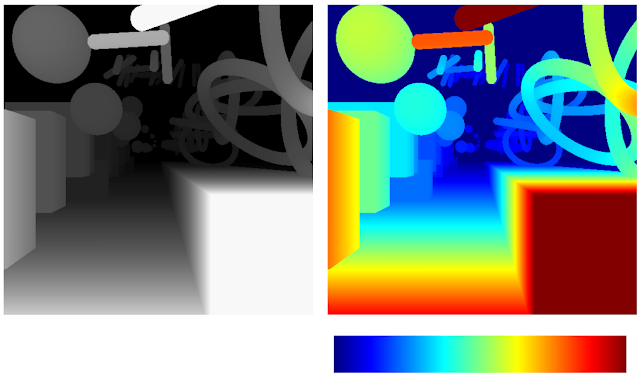 

**You can read the article below or get more info at : https://ai.googleblog.com/2019/08/turbo-improved-rainbow-colormap-for.html**

***************************

One of the most commonly used color mapping algorithms in computer vision applications is Jet, which is high contrast, making it useful for accentuating even weakly distinguished image features. However, if you look at the color map gradient, one can see distinct “bands” of color, most notably in the cyan and yellow regions. This causes sharp transitions when the map is applied to images, which are misleading when the underlying data is actually smoothly varying. 

Today there are many modern alternatives that are uniform and color blind accessible, such as Viridis or Inferno from matplotlib. While these linear lightness maps solve many important issues with Jet, their constraints may make them suboptimal for day to day tasks where the requirements are not as stringent.

****************************

## Turbo Colormap : 

The usage can be found here after that amazing Google AI blog.

**https://gist.github.com/mikhailov-work/ee72ba4191942acecc03fe6da94fc73f**

In [ ]:
turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]

In [ ]:
plt.figure(figsize = (20, 12))
plt.imshow(scan_collection[0], cmap=ListedColormap(turbo_colormap_data))
plt.grid(False)
plt.title("CT-Scanned HU Image in TURBO", fontsize = 18) ; 

Now, we can more clearly see the spaces too! It's good for visual inspection.

## Observing the difference with colormap choice

**JET V VIRIDIS V INFERNO V TURBO**

picking a random image

In [ ]:
sample_image = scan_collection[0]

plt.figure(figsize = (16, 10))
plt.subplot(2,2,1)
plt.imshow(sample_image, cmap = "jet")
plt.grid(False)
plt.title("JET Colormap", fontsize = 16)

plt.subplot(2,2,2)
plt.imshow(sample_image, cmap = "viridis")
plt.grid(False)
plt.title("VIRIDIS Colormap", fontsize = 16)

plt.subplot(2,2,3)
plt.imshow(sample_image, cmap = "inferno")
plt.grid(False)
plt.title("INFERNO Colormap", fontsize = 16)

plt.subplot(2,2,4)
plt.imshow(sample_image, cmap = ListedColormap(turbo_colormap_data))
plt.grid(False)
plt.title("TURBO Colormap", fontsize = 16)

plt.tight_layout()

We can see both JET and Turbo aids us in properly visualizing the scan by, illuminating even the darkest corners. Of course,, we have the bone map too from before. We will keep this insight as a potential reminder for the upcoming visualziation.

let's once again load the dicom attributes and analyze a few of them.

Loading attribute for the first slice.

In [ ]:
print(slices[0])

We can see that the initial attributes such as UID, X-ray tube current, image position, orientation and so on..largely depends upon the working condition and the eqipment setup. The more powerful attributes having a stronger imapact are in the second half.

## Image - 3-D analysis

Let's prepare a dataframe encapsulating all the important information about the images. We will save this as .csv and use it as an external data set source. 

In [ ]:
"""
def extract_information(location_of_images) : 
    image_statistics = pd.DataFrame(index = np.arange(len(location_of_images)), 
                                   columns = ["image path", "rows", "columns", "image_mean", 
                                              "image_standard_deviation", "image_skewness",
                                             "mean_red_value", "mean_green_value", "mean_blue_value"])
    i = 0 
    for path in tqdm(location_of_images) : 
        image = pydicom.dcmread(path)
        image_statistics.iloc[i]["image_path"] = path
        image_statistics,iloc[i]["rows"] = image.shape[0]
        image_statistics.iloc[i]["columns"] = image.shape[1]
        image_statistics.iloc[i]["image_mean"] = np.mean(image)
        image_statistics.iloc[i]["image_standard_deviation"] = np,std(image)
        image_statistics.iloc[i]["image_skewness"] = skew(image)
"""